In [231]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from PIL import Image
import torch.nn.functional as F

                   imageID  classID
0     cars_train/00001.jpg       14
1     cars_train/00002.jpg        3
2     cars_train/00003.jpg       91
3     cars_train/00004.jpg      134
4     cars_train/00005.jpg      106
...                    ...      ...
8139  cars_train/08140.jpg       78
8140  cars_train/08141.jpg      196
8141  cars_train/08142.jpg      163
8142  cars_train/08143.jpg      112
8143  cars_train/08144.jpg       17

[8144 rows x 2 columns]


array([[<AxesSubplot:title={'center':'classID'}>]], dtype=object)

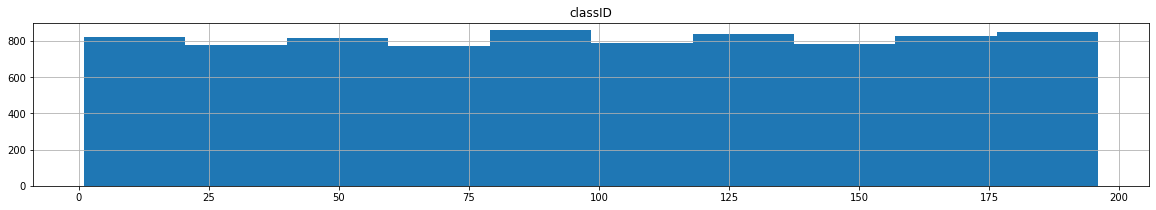

In [232]:
root_path = "/kaggle/input/car-classification-ficosa/"
train_df = pd.read_csv(os.path.join(root_path, "train.csv"))
test_df = pd.read_csv(os.path.join(root_path, "sample_submission.csv"))
print(train_df)
train_df.hist()

In [233]:
train_df.classID.unique()

array([ 14,   3,  91, 134, 106, 123,  89,  96, 167,  58,  49, 186, 135,
        85, 193, 172,  73, 192,  57,  79,  36, 120, 170, 194, 184,  86,
       180, 154, 139,  66, 133, 104,  38,  97, 105, 142,  13, 191, 119,
        25, 177, 173,  42, 148,  15,  53,  44,  65,  90, 124, 114, 190,
       101, 187,   8,  17, 111, 122,   5,  29, 126,  94, 188,  59, 110,
        43,  18, 116, 145,  20, 165, 138, 175, 112,  51,  37,  71,  61,
        74, 162, 131,  88, 121, 137,  83, 147, 161, 109,  28, 144, 136,
       143, 171, 178,  56,  40,  60, 155, 140,  76,  47,  30, 149, 174,
       179,  24, 176,   1, 108,  41,  19, 163,  54,  50,  68, 125, 160,
        93, 183,  45, 189,  48,  77,   6,  16,  12, 128,  23,  11,  63,
        72, 195, 107,  10, 196,  99, 141,  84, 132,   7,  26, 102, 168,
       153,  21,  31, 103,  69,  55,  46, 185, 100, 130, 156, 151,  87,
       169, 127, 158,  75, 182,  62, 166, 181,  22,   9,  67, 113, 117,
       115,  39,  70,  32, 146,   4,  80, 152, 164,  64, 118,  9

[['cars_train/01203.jpg' 171]
 ['cars_train/02737.jpg' 196]
 ['cars_train/07102.jpg' 185]
 ['cars_train/03800.jpg' 68]
 ['cars_train/06091.jpg' 75]]


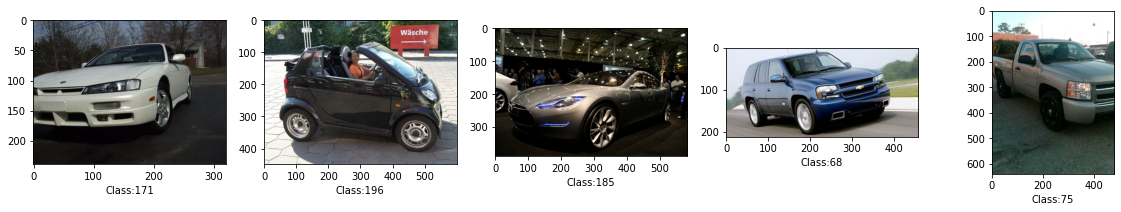

In [234]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

images_path = train_df.iloc[np.random.randint(len(train_df), size=(5))].values
print(images_path)

# create a figure with 5 subplots
fig, axs = plt.subplots(1, 5)

for idx, img_data in enumerate(images_path):
    image = plt.imread(os.path.join(root_path, img_data[0]))
    axs[idx].imshow(image)
    axs[idx].set_xlabel("Class:" + str(img_data[1]))

### from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['classID'])
train_df.head()

In [235]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

In [236]:
from torch.utils.data import Dataset

class Arthopod_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        print("index: ", self.img_path,self.img_data.loc[index, 'classID'])
        img_name = os.path.join(self.img_path,
                                self.img_data.loc[index, 'imageID'])
        image = Image.open(img_name)
        #image = image.convert('RGB')
        image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'classID'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [237]:
dataset = Arthopod_Dataset(train_df,root_path,transform)

In [238]:
dataset_train_size = len(train_df)
dataset_test_size = len(test_df)
print(dataset_train_size)
print(dataset_test_size)
train_indices = list(range(dataset_train_size))
val_indices = list(range(dataset_test_size))
#print(indices)

8144
8041


In [239]:
from torch.utils.data.sampler import SubsetRandomSampler

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [240]:
import torch

batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [241]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

In [242]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

In [243]:
model = Net() # On CPU
#model = Net().to(device)  # On GPU
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)


In [244]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [245]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [246]:
n_epochs = 12
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        #data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            #data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

index:  /kaggle/input/car-classification-ficosa/ 138
index:  /kaggle/input/car-classification-ficosa/ 191
index:  /kaggle/input/car-classification-ficosa/ 192
index:  /kaggle/input/car-classification-ficosa/ 6
index:  /kaggle/input/car-classification-ficosa/ 154
index:  /kaggle/input/car-classification-ficosa/ 53
index:  /kaggle/input/car-classification-ficosa/ 28
index:  /kaggle/input/car-classification-ficosa/ 185
index:  /kaggle/input/car-classification-ficosa/ 59
index:  /kaggle/input/car-classification-ficosa/ 68
index:  /kaggle/input/car-classification-ficosa/ 21
index:  /kaggle/input/car-classification-ficosa/ 153
index:  /kaggle/input/car-classification-ficosa/ 151
index:  /kaggle/input/car-classification-ficosa/ 52
index:  /kaggle/input/car-classification-ficosa/ 116
index:  /kaggle/input/car-classification-ficosa/ 130
index:  /kaggle/input/car-classification-ficosa/ 121
index:  /kaggle/input/car-classification-ficosa/ 63
index:  /kaggle/input/car-classification-ficos

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


IndexError: Target 138 is out of bounds.